In [11]:
import pandas as pd
import numpy as np
import itertools

In [12]:
df = pd.read_excel("Shopping-cart-dataset.xlsx")

    Preprocessing

In [13]:
#Fill in the missing values in the Description column with the help of StockCode column.
null_desc_df = df[df['Description'].isnull() == True]
null_stockCode = null_desc_df["StockCode"].to_list()

for i in range(0, len(null_stockCode)):
    matching_code_df = df[df["StockCode"] == null_stockCode[i]]
    extracted_desc_df = matching_code_df[matching_code_df["Description"].isnull() == False]

    if len(extracted_desc_df) > 0:
        extracted_desc = extracted_desc_df["Description"].to_list()[0]
        df.loc[df["StockCode"] == null_stockCode[i], "Description"] = extracted_desc
    else:
        continue

In [14]:
#Drop the rows with missing values in the Description column which dont have stockcode with filled description.
df.dropna(subset=["Description"], inplace=True)

# The rows with missing values in the CustomerID column are ignored since it doesnt have an impact on the Apriori Algorithm.

In [15]:
groupeddf = df.groupby("Invoice")
trans_df = groupeddf["Description"].apply(list)
all_trans = trans_df.to_list()

    Apriori Algorithm

In [16]:
#Step - 1
def generate_freq_lvl1(sup,total_rows):

    lvl1_item_counts = {}

    for i in all_trans:

        for j in i:
            if j in lvl1_item_counts:
                lvl1_item_counts[j] += 1
            else:
                lvl1_item_counts[j] = 1


    lvl1_qualified_items = []
    lvl1_pruned_items = []

    for i in lvl1_item_counts:
        val = lvl1_item_counts[i] / total_rows
        if  val >= sup:
            lvl1_qualified_items.append(i)
        else:
            lvl1_pruned_items.append(i)

    print("Level 1 qualified Items: ", lvl1_qualified_items[:5])
    print("Level 1 pruned Items: ", lvl1_pruned_items[:5])

    return lvl1_qualified_items,lvl1_item_counts

# Step - 2

# Helper Functions for Step2
def get_subsets(s, n):
    return list(itertools.combinations(s, n))

def get_candidates(k_qualified_items):
    candidates = set()
    for itemset1 in k_qualified_items:
        for itemset2 in k_qualified_items:

            if itemset1 != itemset2:
                itemset1 = set(itemset1)
                candidate = itemset1.union(set(itemset2))
                
                if len(candidate) == len(itemset1)+1:
                    candidates.add(frozenset(candidate))
    return candidates

def generate_freq_lvlk(lvl1_qualified_items,sup,total_rows):

    all_lvl_item_counts = {}
    save_lvlk_qualified_items = []
    for x in range(2,6):

        if x > 2:
            lvlk_subsets = get_candidates(lvlk_qualified_items)
            lvlk_item_counts = {}
        else:
            lvlk_subsets = get_subsets(lvl1_qualified_items, x)
            lvlk_item_counts = {}
            
        for i in lvlk_subsets:
            de_ref = list(i)
            for j in all_trans:

                match = 0
                for d in range(0,len(de_ref)):
                    if de_ref[d] in j:
                        match = 1
                    else:
                        match = 0
                        break
                
                if match == 1:
                    if i in lvlk_item_counts:
                        all_lvl_item_counts[i] += 1
                        lvlk_item_counts[i] += 1
                    else:
                        all_lvl_item_counts[i] = 1
                        lvlk_item_counts[i] = 1
                else:
                    continue

                del match

            del de_ref

        lvlk_qualified_items = []
        lvlk_pruned_items = []

        for i in lvlk_item_counts:

            val = lvlk_item_counts[i] / total_rows
            if  val >= sup:
                lvlk_qualified_items.append(i)
            else:
                lvlk_pruned_items.append(i)

        if len(lvlk_qualified_items) == 0:
            break

        print("Level ", x, " qualified Items: ", lvlk_qualified_items[:5])
        print("Level ", x, " pruned Items: ", lvlk_pruned_items[:5])

        save_lvlk_qualified_items.append(lvlk_qualified_items)

    return lvlk_qualified_items,all_lvl_item_counts,save_lvlk_qualified_items

def generate_assoc_rules(frequent_itemsets, itemset_counts, min_confidence):
    assoc_rules = []
    for itemset in frequent_itemsets:
        for i in range(1, len(itemset)):
            for subset in itertools.combinations(itemset, i):
                
                if len(subset) == 1:
                    subset = list(subset)
                    try:
                        confidence = itemset_counts[frozenset(itemset)] / itemset_counts[subset[0]]    
                    except KeyError:
                        continue
                else:
                    try:
                        confidence = itemset_counts[frozenset(itemset)] / itemset_counts[tuple(subset)]
                    except KeyError:
                        continue
                 
                if confidence >= min_confidence:
                    classify = None
                    
                    y_lst = list(itemset)

                    for i in list(subset):
                        y_lst.remove(i)
                    y = tuple(y_lst)

                    if confidence >= 0.8:
                        classify = "Strong"
                    else:
                        classify = "Weak"

                    rule = (subset, y)
                    assoc_rules.append((rule,classify))
    return assoc_rules

    Runner Code for Apriori

In [17]:
sup = 0.012
total_rows = len(all_trans)

def Apriori(sup,total_rows):

    qualified_items,lvl1_item_count =  generate_freq_lvl1(sup,total_rows)

    lvlk_qualified_items,all_lvl_item_counts,saved_lvl =  generate_freq_lvlk(qualified_items,sup,total_rows)

    freq_itemsets = lvlk_qualified_items.copy()

    all_lvl_item_counts.update(lvl1_item_count)

    for i in range(0, len(freq_itemsets)):
        freq_itemsets[i] = list(freq_itemsets[i])

    conf = 0.6
    rules = generate_assoc_rules(freq_itemsets, all_lvl_item_counts, conf)

    return rules,saved_lvl

rules,saved_lvl = Apriori(sup,total_rows)

print("Rules Generated:\n")

for rule,classify in rules:
    left,right = rule
    print(left, " => ", right, " : ", classify)

Level 1 qualified Items:  ['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN', 'CREAM CUPID HEARTS COAT HANGER', 'KNITTED UNION FLAG HOT WATER BOTTLE', 'RED WOOLLY HOTTIE WHITE HEART.']
Level 1 pruned Items:  ['HAND WARMER RED POLKA DOT', 'BOX OF 6 ASSORTED COLOUR TEASPOONS', 'RECIPE BOX WITH METAL HEART', 'RED COAT RACK PARIS FASHION', 'YELLOW COAT RACK PARIS FASHION']
Level  2  qualified Items:  [('WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN'), ('WHITE HANGING HEART T-LIGHT HOLDER', 'CREAM CUPID HEARTS COAT HANGER'), ('WHITE HANGING HEART T-LIGHT HOLDER', 'KNITTED UNION FLAG HOT WATER BOTTLE'), ('WHITE HANGING HEART T-LIGHT HOLDER', 'RED WOOLLY HOTTIE WHITE HEART.'), ('WHITE HANGING HEART T-LIGHT HOLDER', 'SET 7 BABUSHKA NESTING BOXES')]
Level  2  pruned Items:  [('WHITE HANGING HEART T-LIGHT HOLDER', 'HAND WARMER UNION JACK'), ('WHITE HANGING HEART T-LIGHT HOLDER', "POPPY'S PLAYHOUSE BEDROOM "), ('WHITE HANGING HEART T-LIGHT HOLDER', "POPPY'S PLAYHOUSE KITCHEN

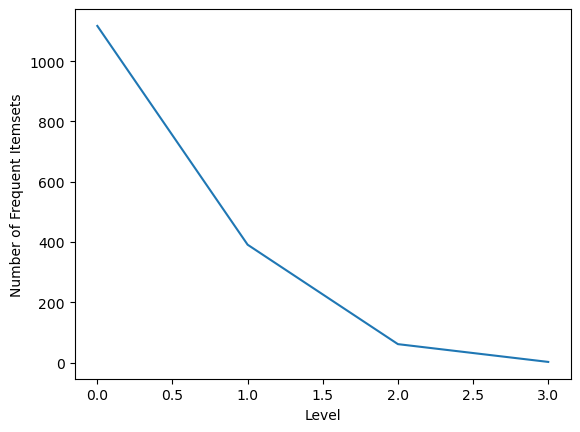

In [24]:
import matplotlib.pyplot as plt

lengths = []

for i in saved_lvl:
    lengths.append(len(i))

plt.xlabel("Level")
plt.ylabel("Number of Frequent Itemsets")
plt.plot(lengths)

    Q2

In [29]:
MMS = {'WHITE HANGING HEART T-LIGHT HOLDER':0.001,
       'KNITTED UNION FLAG HOT WATER BOTTLE':0.002,
       'JAM MAKING SET WITH JARS':0.001,
       'BLUE SWEETHEART BRACELET':0.02,
       'PLEASE ONE PERSON METAL SIGN':0.001}

total_rows = len(all_trans)

In [32]:

def lvl1_freq_items(MMS,total_rows):

    item_counts = {}

    for i in MMS.keys():
        for x in all_trans:
            if i in x:
                if i in item_counts:
                    item_counts[i] += 1
                else:
                    item_counts[i] = 1

    L = []
    MIS = min(MMS.values())

    for i in MMS.keys():
        sup = item_counts[i] / total_rows
        if sup >= MIS:
            L.append(i)

    chosen = []
    for i in L:
        if item_counts[i] / total_rows >= MMS[i]:
            chosen.append(i)

    return chosen,item_counts


def lvlk_freq_itemsets(chosen,item_counts,diff):
    MIS = min(MMS.values())
    saved_lvlk_freq_items = []
    for i in range(2,6):

        if i == 2:
            subsets = list(itertools.combinations(chosen, i))

            for y in subsets:
                for x in all_trans:
                    if(all(w in x for w in y)):
                        if y in item_counts:
                            item_counts[y] += 1
                        else:
                            item_counts[y] = 1
        else:
            candidates = set()
            for itemset1 in lvlk_freq_items:
                for itemset2 in lvlk_freq_items:

                    if itemset1 != itemset2:
                        itemset1 = set(itemset1)
                        candidate = itemset1.union(set(itemset2))
                        
                        if len(candidate) == len(itemset1)+1:
                            candidates.add(frozenset(candidate))

            subsets = list(candidates)


            for y in subsets:
                temp = list(y)
                for x in all_trans:
                    if(all(w in x for w in temp)):
                        if y in item_counts:
                            item_counts[y] += 1
                        else:
                            item_counts[y] = 1
                        
                del temp
            
        lvlk_candidate_items = []
        lvlk_pruned_items = []

        if len(subsets) == 0:
            print("No more candidate items")
            break

        for k in subsets:
            
            min_mis = 5

            if i > 2:
                for f in k:
                    if MMS[f] < min_mis:
                        min_mis = MMS[f]
            else:
                for f in k:
                    if MMS[f] < min_mis:
                        min_mis = MMS[f]

            if i == 2:

                left,right = k
                
                sup_left = item_counts[left] / total_rows
                sup_right = item_counts[right] / total_rows

                if sup_right > MIS and abs(sup_left - sup_right) < diff:
                    lvlk_candidate_items.append(k)
                else:
                    lvlk_pruned_items.append(k)

                del left
                del right

            else:
                first_item = list(k)[0]

                if min_mis >= MMS[first_item]:
                    lvlk_candidate_items.append(k)
                else:
                    lvlk_pruned_items.append(k)

            del min_mis

        lvlk_freq_items = []


        for d in lvlk_candidate_items:
            min_i_mis = 5

            if i == 2:        
                for k in d:
                    if MMS[k] < min_i_mis:
                        min_i_mis = MMS[k]
            else:
                for k in d:
                    if MMS[k] < min_i_mis:
                        min_i_mis = MMS[k]

            for x in d:
                if i == 2:
                    if item_counts[x] / total_rows < min_i_mis:
                        lvlk_candidate_items.remove(d)
                        lvlk_pruned_items.append(d)
                        break
                    else:
                        if d in lvlk_freq_items:
                            continue
                        lvlk_freq_items.append(d)
                else:
                    if item_counts[x] / total_rows < min_i_mis:
                        lvlk_candidate_items.remove(d)
                        lvlk_pruned_items.append(d)
                        break
                    else:
                        if d in lvlk_freq_items:
                            continue
                        lvlk_freq_items.append(d)

        if len(lvlk_freq_items) == 0:
            break
        
        saved_lvlk_freq_items.append(lvlk_freq_items)
        print("Frequent Itemsets of level "+str(i)+":",lvlk_freq_items[:5])
        print("Pruned Itemsets of level "+str(i)+":",lvlk_pruned_items[:5])

        del lvlk_candidate_items
        del subsets
        del lvlk_pruned_items

    return lvlk_freq_items,item_counts,saved_lvlk_freq_items

def generate_assoc_rules(freq_itemsets, all_lvl_item_counts, conf):

    rules = []
    for itemset in freq_itemsets:

        for i in range(1, len(itemset)):
            for rule in itertools.combinations(itemset, i):

                left = set(rule)
                right = set(itemset) - left
                if len(left) > 0 and len(right) > 0:
                    right = frozenset(right)
                    
                    if len(left) == 1:
                        left = list(left)[0]
                    elif len(left) == 2:
                        left = tuple(left)
                    else:
                        left = frozenset(left)

                    try:
                        confi = all_lvl_item_counts[frozenset(itemset)] / all_lvl_item_counts[left]
                    except KeyError:
                        if len(left) == 2:
                            left = (left[1], left[0])
                            confi = all_lvl_item_counts[frozenset(itemset)] / all_lvl_item_counts[left]
                        else:
                            continue

                    if confi >= conf:
                        if conf >= 0.8:
                            classify = "Strong"
                        else:
                            classify = "Weak"
                        rules.append((left, right, classify))
    return rules

    Runner Code For MMS Apriori Algo

In [33]:
def MMS_Apriori(MMS,total_rows):

    chosen,item_counts = lvl1_freq_items(MMS,total_rows)
    diff = 0.2
    
    freq_itemsets,item_count,saved_lvls = lvlk_freq_itemsets(chosen,item_counts,diff)

    item_count.update(item_counts)

    for j in range(0, len(freq_itemsets)):
        freq_itemsets[j] = list(freq_itemsets[j])
    
    conf = 0.5
    rules = generate_assoc_rules(freq_itemsets, item_counts, conf)

    return rules,saved_lvls

total_rows = len(all_trans)
rules,saved_lvls = MMS_Apriori(MMS,total_rows)

print("Rules: ")

for i in rules:
    left,right,classify = i
    print(tuple(left) ,"=>", tuple(right), classify)

Frequent Itemsets of level 2: [('WHITE HANGING HEART T-LIGHT HOLDER', 'KNITTED UNION FLAG HOT WATER BOTTLE'), ('WHITE HANGING HEART T-LIGHT HOLDER', 'JAM MAKING SET WITH JARS'), ('WHITE HANGING HEART T-LIGHT HOLDER', 'PLEASE ONE PERSON METAL SIGN'), ('KNITTED UNION FLAG HOT WATER BOTTLE', 'JAM MAKING SET WITH JARS'), ('KNITTED UNION FLAG HOT WATER BOTTLE', 'PLEASE ONE PERSON METAL SIGN')]
Pruned Itemsets of level 2: []
Frequent Itemsets of level 3: [frozenset({'WHITE HANGING HEART T-LIGHT HOLDER', 'KNITTED UNION FLAG HOT WATER BOTTLE', 'JAM MAKING SET WITH JARS'}), frozenset({'WHITE HANGING HEART T-LIGHT HOLDER', 'PLEASE ONE PERSON METAL SIGN', 'JAM MAKING SET WITH JARS'}), frozenset({'JAM MAKING SET WITH JARS', 'KNITTED UNION FLAG HOT WATER BOTTLE', 'PLEASE ONE PERSON METAL SIGN'}), frozenset({'WHITE HANGING HEART T-LIGHT HOLDER', 'KNITTED UNION FLAG HOT WATER BOTTLE', 'PLEASE ONE PERSON METAL SIGN'})]
Pruned Itemsets of level 3: []
Frequent Itemsets of level 4: [frozenset({'JAM MAKIN

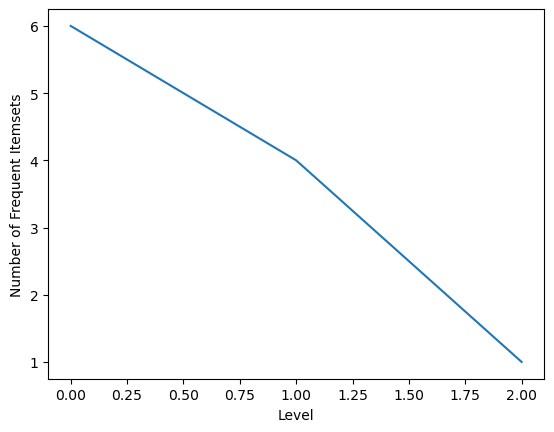

In [34]:
lengths = []

for i in saved_lvls:
    lengths.append(len(i))

plt.xlabel("Level")
plt.ylabel("Number of Frequent Itemsets")
plt.plot(lengths)